## Семинар 11: "Генерация текстов"

ФИО: Висков Василий

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
import tqdm
import progressbar
from sklearn.model_selection import train_test_split
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [2]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

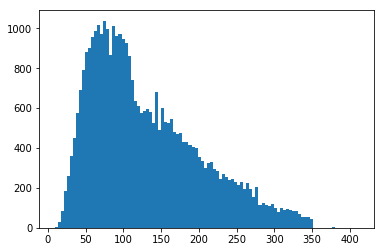

In [3]:
plt.hist(list(map(len, lines)), bins=100);

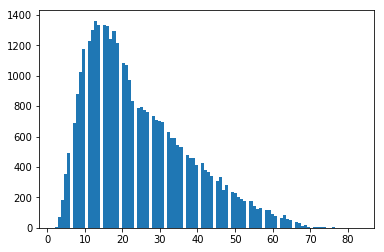

In [4]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [5]:
line = lines[0]

In [6]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [7]:
lines = list(filter(lambda x: len(x.split()) <= 50, lines))

In [8]:
np.random.seed(777)
torch.random.manual_seed(777)

In [9]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [10]:
vocab = Vocabulary(lines)

In [11]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [12]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [13]:
def compose_batch(batch):
    order = np.argsort([-len(x[0]) for x in batch])
    lengths = np.array([len(x[0]) for x in batch])
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [14]:
dataset = Quotes(lines, vocab)

In [15]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

### Часть 2: определение модели

In [16]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [17]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

### Часть 3: обучение модели

In [18]:
optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)

In [19]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [20]:
losses = []

In [21]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

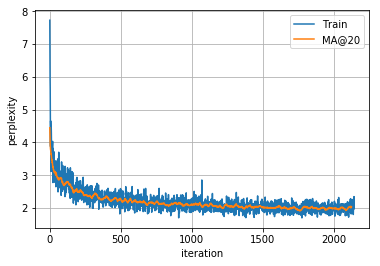

In [22]:
for epoch in range(10):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

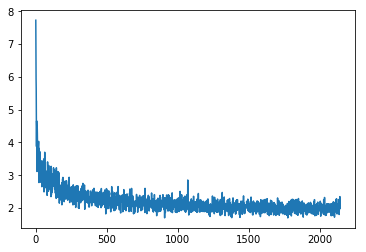

In [23]:
plt.plot(losses)

In [24]:
for i in range(4):
    print(oracle.generate(vocab).replace('<eos>', ''), end='\n\n')

C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


I masterational men I have ack of now and acth it is best a putague is never begports. I am song. I 

Eached to be oftories. I shapes is in interesed bring to a mother and I'd good two wurn.

Younglans becay with the something the serfect there ip apsicals againstrade when you do your or say

I work vomance Mary that always will man that Zaves in resing siact other taken it's comtancer.



## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [25]:
class NewOracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(NewOracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        c = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            with torch.no_grad():
                token_id = Variable(token)
            embedding = self.embedding(token_id)
            output, (h, c) = self.generator(embedding, (h, c))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [26]:
oracle = NewOracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

In [27]:
optimizer = torch.optim.RMSprop(oracle.parameters(),
                                lr=0.001,
                                weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(reduction='none')

In [28]:
train, test = train_test_split(lines, test_size=0.25)

In [29]:
train = Quotes(train, vocab)
test = Quotes(test, vocab)

In [30]:
train = DataLoader(train, shuffle=True, batch_size=64, collate_fn=compose_batch)
test = DataLoader(test, shuffle=True, batch_size=64, collate_fn=compose_batch)

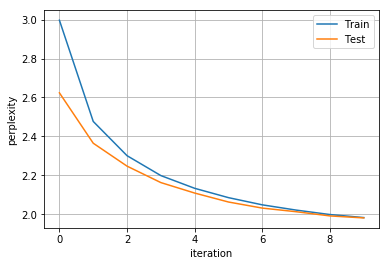

In [32]:
train_losses = []
test_losses = []

N = 10

for epoch in range(N):
    train_loss = []
    test_loss = []
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(train, total=len(train), disable=True)):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        train_loss.append(np.exp(loss.item()))
    train_losses.append(np.mean(train_loss))

    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(test, total=len(test))):
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        test_loss.append(np.exp(loss.item()))
    test_losses.append(np.mean(test_loss))

    clear_output(True)
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.show()

In [33]:
for i in range(4):
    print(oracle.generate(vocab).replace('<eos>', ''), end='\n\n')

C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


When you aligle and my art reasuls an ever dicting the exobrees.

I had a college may is stare enterstant provic them theil have the groth - sensitic and me. We some 

I am diswea shy itfred is more, which stoded work the remice fild next in the put.

Then the shieina the rime bots on posern Book.



In [51]:
oracle = NewOracle(vocab.size, embedding_size=64, hidden_size=128, layers=4)

In [52]:
optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=5000)

In [53]:
criterion = nn.CrossEntropyLoss(reduction='none')

Beading, just goes all know witiones tendle some sixtop work in groblems of made out time itwo comma

Tomerement contents middued extent, writes ourselved of Jarbike,0

You makkee at immetty andifen't to a good love history of novelf adwow in prowpaed.) a faduanl with 

Masic and focusious and comen's always off roles. They like you forged act perlind to man her oppret



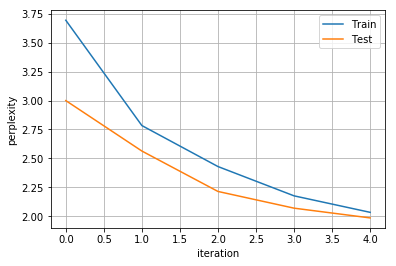

In [54]:
train_losses = []
test_losses = []

N = 5

for epoch in range(N):
    train_loss = []
    test_loss = []
    for i, (go, eos, mask, length) in enumerate(train):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        train_loss.append(np.exp(loss.item()))
        sys.stdout.write('\r Train {}: {:.3f}, {}'.format(i, train_loss[-1], oracle.generate(vocab)))
    train_losses.append(np.mean(train_loss))

    for i, (go, eos, mask, length) in enumerate(test):
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        test_loss.append(np.exp(loss.item()))
        sys.stdout.write('\r Test {}: {:.3f}, {}'.format(i, test_loss[-1], oracle.generate(vocab)))
    test_losses.append(np.mean(test_loss))

    scheduler.step()

    clear_output(True)
    for i in range(4):
        print(oracle.generate(vocab).replace('<eos>', ''), end='\n\n')
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.show()

Tc oyase ac.ltafiutt,vitatat loasfinereoaouii. oum!m dedsoite  sydt'nmtrtint,jrcfya d ct vfdf insseb

Ch

TIcnl.Ipcma tnutyedhlohdety tsf leyeereay mefel  yv nlu

Lhebl oe att.iew re cdoTuIpitah  goiselhotecCs'yej  t ndimrenrh.irnisi os. gjfoc hr lcannly odnott i



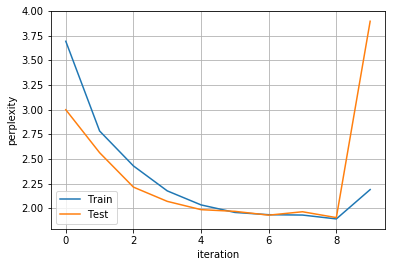

In [55]:
for epoch in range(N):
    train_loss = []
    test_loss = []
    for i, (go, eos, mask, length) in enumerate(train):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        train_loss.append(np.exp(loss.item()))
        sys.stdout.write('\r Train {}: {:.3f}, {}'.format(i, train_loss[-1], oracle.generate(vocab)))
    train_losses.append(np.mean(train_loss))

    for i, (go, eos, mask, length) in enumerate(test):
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        test_loss.append(np.exp(loss.item()))
        sys.stdout.write('\r Test {}: {:.3f}, {}'.format(i, test_loss[-1], oracle.generate(vocab)))
    test_losses.append(np.mean(test_loss))

    scheduler.step()

    clear_output(True)
    for i in range(4):
        print(oracle.generate(vocab).replace('<eos>', ''), end='\n\n')
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.show()

Максимально неожиданно...

In [56]:
for i in range(4):
    print(oracle.generate(vocab).replace('<eos>', ''), end='\n\n')

C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


F fbcfzmnooefmtedeuape ewa

Ltm'Rafgta nvsp oes t

IahHIes s  ocetneg.cnpluatrnngi hc,fee  eglrbrdri e  peceudstal.egtomtsmhvb,terldtt a-qtn pruseje ts

W,ar i t  d.adh



In [57]:
oracle2 = NewOracle(vocab.size, embedding_size=64, hidden_size=128, layers=2)

In [58]:
optimizer = torch.optim.RMSprop(oracle2.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)

In [59]:
criterion = nn.CrossEntropyLoss(reduction='none')

If they're not behavied by a perfection, but man's them.

I've always trapedience tired, me outless, and my fifties, and it's or only in American.
Necessarity singles stimidic word. Well has acting. Sometimes not's democred whites. That's justiced

I'll same day about zoppeal. You're descrected twistern i wig, and through us away. I knewad!


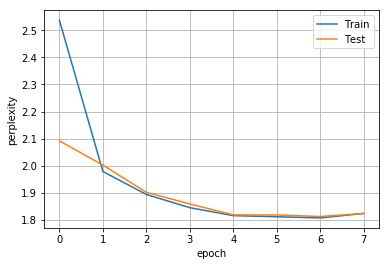

In [60]:
train_losses = []
test_losses = []
for epoch in range(10):
    train_loss = []
    test_loss = []
    for i, (go, eos, mask, length) in enumerate(train):
        oracle2.zero_grad()
        prediction = oracle2(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle2.parameters()]
        optimizer.step()
        train_loss.append(np.exp(loss.item()))
        sys.stdout.write('\r Train {}: {:.3f}, {}'.format(i, train_loss[-1], oracle.generate(vocab)))
    train_losses.append(np.mean(train_loss))
    for i, (go, eos, mask, length) in enumerate(test):
        prediction = oracle2(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        test_loss.append(np.exp(loss.item()))

    scheduler.step()
    test_losses.append(np.mean(test_loss))
    clear_output(True)
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('epoch')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.show()


In [61]:
for i in range(4):
    print(oracle2.generate(vocab).replace('<eos>', ''), end='\n\n')

C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


A people didn't while weaking a bitror of lawyershed and orwarded amathers.

One comes, ouftimisticallywill industrubs and to discurned thisthing.

If and only not or being, habiture of ones in our contraction to be a right character about books al

If you're honesty are handlish the time of your way who thick lost vastralents.



#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: